# Acoustic modelling

Physical modelling is defined in Stride through `stride.Operator` objects that represent specific implementations of a numerical solver applied to a partial differential equation. Stride does not prescribe a specific solver or numerical method, and different codes and implementations can be integrated with it as long as they conform to the `stride.Operator` interface.

By default, Stride integrates with the [Devito](https://www.devitoproject.org/) library, a domain specific language (DSL) that generates highly optimised finite-difference code from math-like symbolic differential equations. This means that anyone can easily add new physics to Stride, which will also run on both CPUs and GPUs without any code changes.  

Using Devito, we provide an implementation of the second-order isotropic acoustic wave equation, which is governed by the equation,

$$
    \frac{1}{v_p^2} \frac{\partial^2 p}{\partial t^2} = \rho \nabla \cdot (\frac{1}{\rho} \nabla p) + \eta \frac{\partial}{\partial t} (-\nabla^2)^{y/2} p
$$

where $p(t, \mathbf{x})$ is the pressure, $v_p(\mathbf{x})$ is the longitudinal speed of sound, $\rho(\mathbf{x})$ is the mass density, $\eta = -2 \alpha_0 v_p^{y-1}$, and $\alpha_0(\mathbf{x})$ is the absorption coefficient. 

The implementation of the acoustic wave equation is fourth-order accurate in time and tenth-order accurate in space, with options for both constant and variable speed of sound, density and attenuation. Additionally, sources and receivers in Stride can be defined in any locations off the grid.

## Constant density and no attenuation

As usual, let's start by creating a spatiotemporal grid:

In [1]:
from stride import Space, Time, Grid
%matplotlib notebook

space = Space(shape=(200, 200), extra=(50, 50), absorbing=(40, 40), spacing=0.4e-3)
time = Time(start=0.0e-6, step=0.05e-6, num=2000)

grid = Grid(space, time)

In this case, we have added some extra arguments to the generation of the spatial grid: `extra` and `absorbing`. The parameter `extra` defines the amount of padding (in gridpoints) that is added to the spatial working area in each dimension, while `absorbing` defines how much of this padding area will be occupied by the absorbing boundary. Setting these to zero will eliminate the padding area.

Let's also create a `problem` object to encapsulate all the necessary components of the modelling.

In [2]:
from stride import Problem

problem = Problem(name='example', space=space, time=time)

We will now create the transducers and some geometry:

<IPython.core.display.Javascript object>


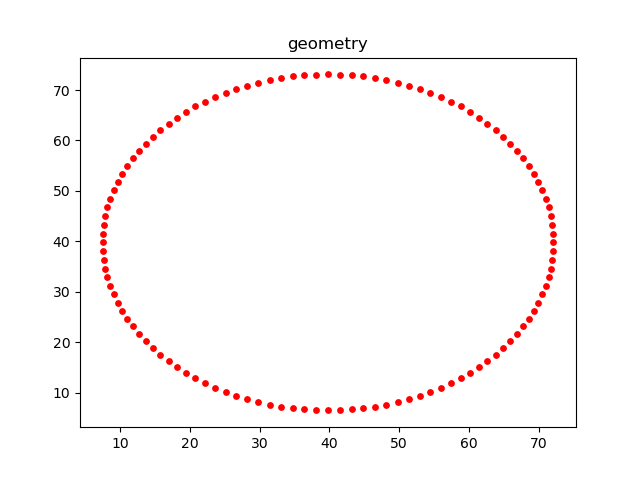

<AxesSubplot:title={'center':'geometry'}>

In [3]:
# Create transducers
# the default option will create a single point transducer
problem.transducers.default()

# Create geometry
# a default elliptical geometry will be generated in this case
num_locations = 120
problem.geometry.default('elliptical', num_locations)

# Plot the resulting geometry
problem.geometry.plot()

It is important to note that the location of transducers in the geometry does not need to coincide with the finite-difference grid: Stride will use Devito's ability to interpolate the location of these points. By default, Stride will use a lower-accuracy bi-/tri-linear interpolation to do this, but higher-order sinc interpolation is also available. To learn more about how to switch between different types of interpolation check `IsoAcousticDevito.__doc__`. 

For this example, we will create a single shot, that will fire a tone-burst, while all elements in the geometry act as receivers.

<IPython.core.display.Javascript object>


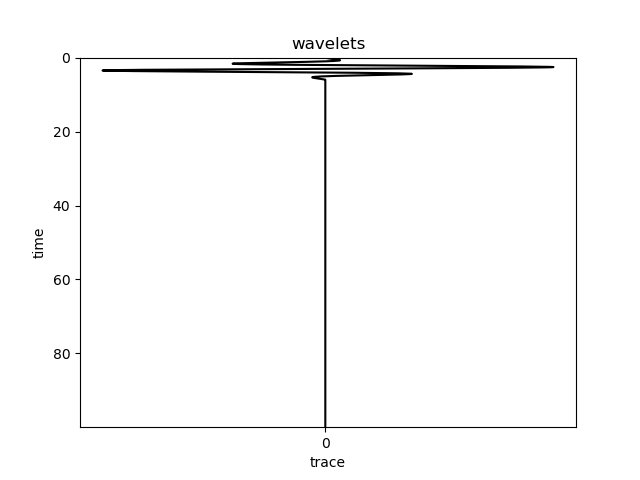

[(array([[0.]]),
  <AxesSubplot:title={'center':'wavelets'}, xlabel='trace', ylabel='time'>)]

In [4]:
from stride import Shot
from stride.utils import wavelets

# Create shot
source = problem.geometry.locations[0]
receivers = problem.geometry.locations

shot = Shot(id=0,
            sources=[source], receivers=receivers,
            geometry=problem.geometry, problem=problem)

# and add it to the acquisition
problem.acquisitions.add(shot)

# Create a wavelet for the shot
f_centre = 0.50e6
n_cycles = 3

shot.wavelets.data[0] = wavelets.tone_burst(f_centre, n_cycles, time.num, time.step)

# Plot the generated wavelet
shot.plot()

Because we are going to run the acoustic modelling using constant density and no attenuation, the only thing that remains is creating a sound-speed scalar field.

<IPython.core.display.Javascript object>


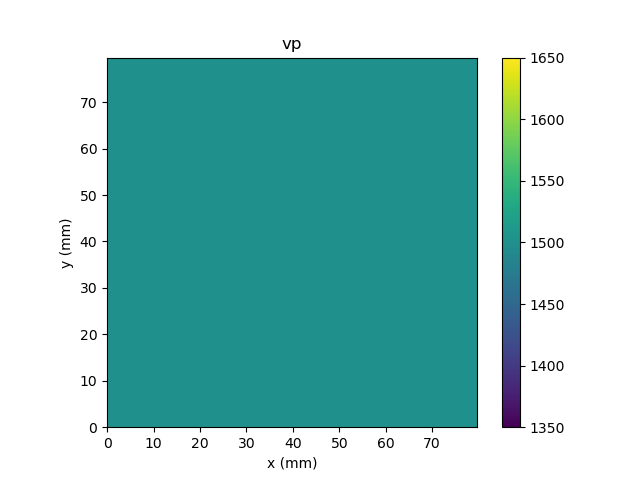

<AxesSubplot:title={'center':'vp'}, xlabel='x (mm)', ylabel='y (mm)'>

In [5]:
from stride import ScalarField

vp = ScalarField(name='vp', grid=problem.grid)
vp.fill(1500.)  # [m/s]

problem.medium.add(vp)

# Plot the field
vp.plot()

We are now ready to run our PDE:

Default Devito configuration:
	 * autotuning=['aggressive', 'runtime']
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp
(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 0.260-0.730 MHz
(ShotID 0) Spatial grid spacing (0.400 mm | 5.137 PPW) is below dispersion limit (0.411 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.050 μs | 18%) is below OT2 limit (0.120 μs)
(ShotID 0) Selected undersampling level 6
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 0.0004, h_y: 0.0004}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 2.15 s
  * lowering.Expressions: 0.79 s (36.9 %)
  * lowering.Clusters: 0.68 s (31.7 %)
  * lowering.IET: 0.51 s (23.8 %)
Flops reduction after symbolic optimization: [317 --> 210]
recompiling for non-existent cache dir (/tmp/devito-codepy-uid1000/b39364e/3dfd6e501766f4f428eb76d27549b45f).
gcc -O3 -

<IPython.core.display.Javascript object>


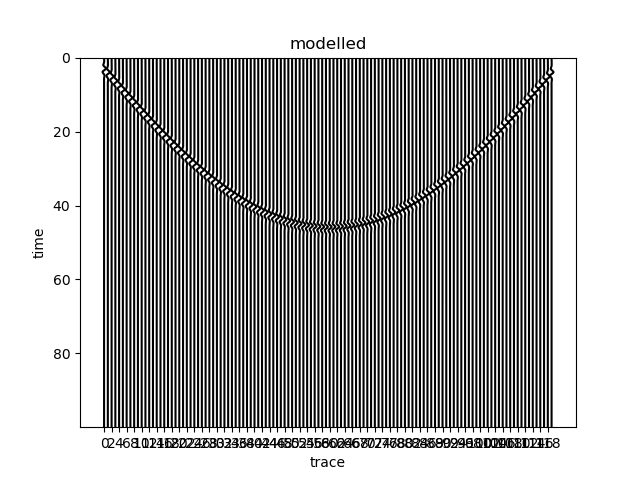

<IPython.core.display.Javascript object>


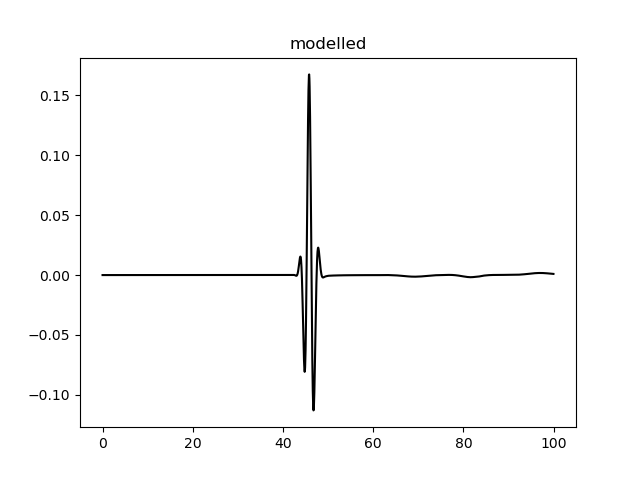

<AxesSubplot:title={'center':'modelled'}>

In [6]:
from stride import IsoAcousticDevito

# Instantiate the PDE operator,
pde = IsoAcousticDevito(space=space, time=time)

# create a sub-problem for the shot,
sub_problem = problem.sub_problem(shot.id)

# and run it forward
traces = await pde(shot.wavelets, vp, problem=sub_problem)

# Plot the resulting traces
_ = traces.plot()
traces.plot_one(60)

## Variable density and no attenuation

Let's now introduce variable density into our previous example.

To do this, we only need to create another scalar field that contains our density information:

<IPython.core.display.Javascript object>


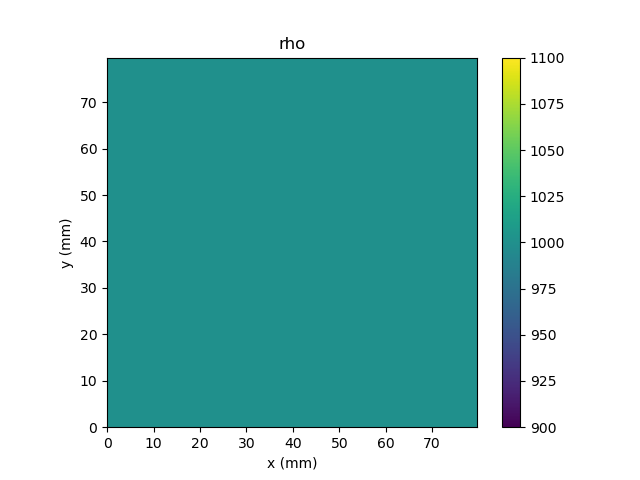

<AxesSubplot:title={'center':'rho'}, xlabel='x (mm)', ylabel='y (mm)'>

In [7]:
rho = ScalarField(name='rho', grid=problem.grid)
rho.fill(1000.)  # [kg/m^3]

problem.medium.add(rho)

# Plot the field
rho.plot()

Then, we can run our PDE operator with the added field.

(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 0.260-0.730 MHz
(ShotID 0) Spatial grid spacing (0.400 mm | 5.137 PPW) is below dispersion limit (0.411 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.050 μs | 18%) is below OT2 limit (0.120 μs)
(ShotID 0) Selected undersampling level 6
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 0.0004, h_y: 0.0004}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 5.70 s
  * lowering.Clusters: 2.80 s (49.2 %)
     * specializing.Clusters: 1.31 s (23.0 %)
  * lowering.Expressions: 2.05 s (36.0 %)
Flops reduction after symbolic optimization: [2302 --> 355]
recompiling for non-existent cache dir (/tmp/devito-codepy-uid1000/6a87e53/36f38459a662ca3e78cc3b0b0820aa4a).
gcc -O3 -g -fPIC -Wall -std=c99 -march=native -Wno-unused-result -Wno-unused-variable -Wno-unused-but-set-variable -ffast-math -shared -fopenmp 

<IPython.core.display.Javascript object>


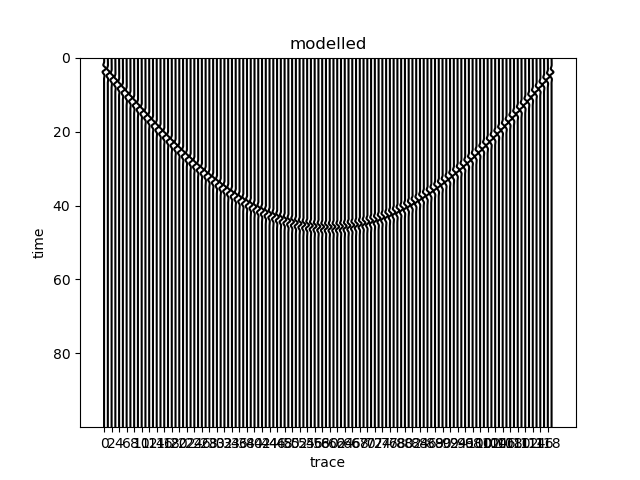

<IPython.core.display.Javascript object>


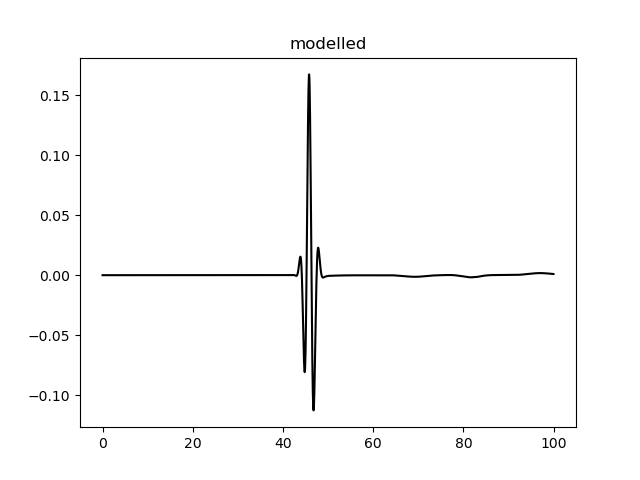

<AxesSubplot:title={'center':'modelled'}>

In [8]:
# Clear the previously compiled operator
pde.clear_operators()

# and run it forward
traces = await pde(shot.wavelets, vp, rho, problem=sub_problem)

# Plot the resulting traces
_ = traces.plot()
traces.plot_one(60)

## Variable density and attenuation

We can also add some attenuation to our acoustic run by creating a further scalar field.

<IPython.core.display.Javascript object>


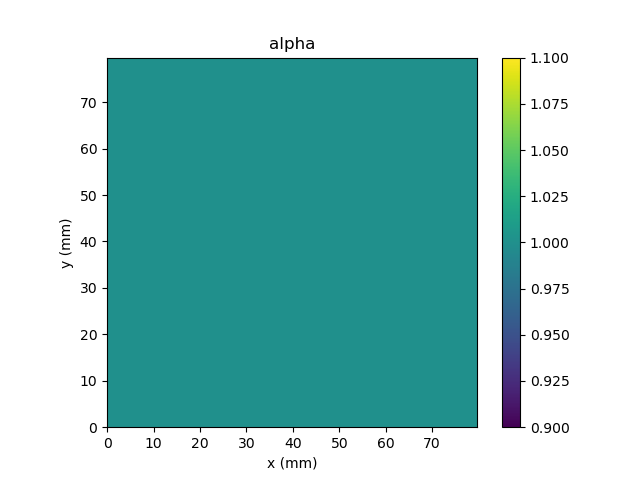

<AxesSubplot:title={'center':'alpha'}, xlabel='x (mm)', ylabel='y (mm)'>

In [9]:
alpha = ScalarField(name='alpha', grid=problem.grid)
alpha.fill(1.)  # [Np/m]

problem.medium.add(alpha)

# Plot the field
alpha.plot()

And then running the PDE operator as before using the new field.

(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 0.260-0.730 MHz
(ShotID 0) Spatial grid spacing (0.400 mm | 5.137 PPW) is below dispersion limit (0.411 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.050 μs | 18%) is below OT2 limit (0.120 μs)
(ShotID 0) Selected undersampling level 6
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 0.0004, h_y: 0.0004}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 5.89 s
  * lowering.Clusters: 2.90 s (49.3 %)
     * specializing.Clusters: 1.44 s (24.5 %)
  * lowering.Expressions: 1.93 s (32.9 %)
Flops reduction after symbolic optimization: [2368 --> 421]
recompiling for non-existent cache dir (/tmp/devito-codepy-uid1000/e7f00f0/ed4a81953688adc7d4d40bd53d4cade1).
gcc -O3 -g -fPIC -Wall -std=c99 -march=native -Wno-unused-result -Wno-unused-variable -Wno-unused-but-set-variable -ffast-math -shared -fopenmp 

<IPython.core.display.Javascript object>


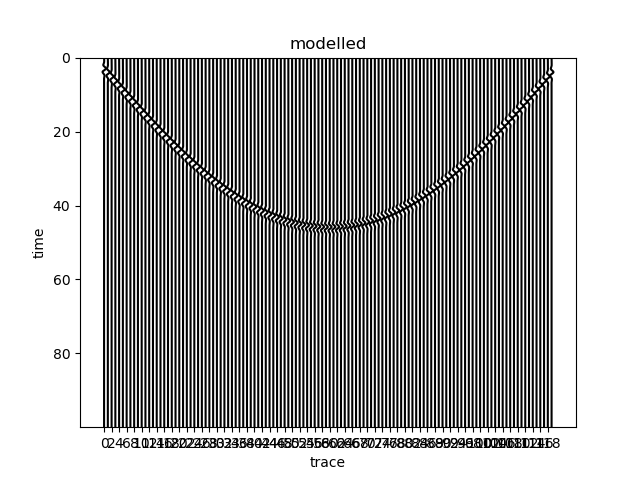

<IPython.core.display.Javascript object>


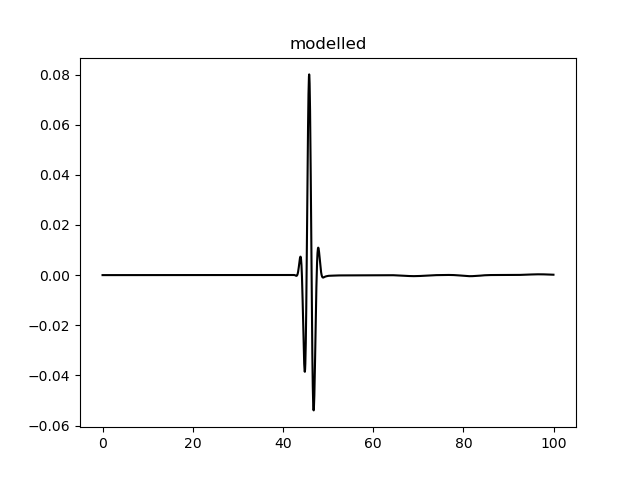

<AxesSubplot:title={'center':'modelled'}>

In [10]:
# Clear the previously compiled operator
pde.clear_operators()

# and run it forward
traces = await pde(shot.wavelets, vp, rho, alpha, problem=sub_problem)

# Plot the resulting traces
_ = traces.plot()
traces.plot_one(60)

Attenuation in the viscoacoustic wave equation follows a power law, that is $\alpha \propto \alpha_0 \omega^y$ for some absorption coefficient $\alpha_0$ and the temporal frequency $\omega$. In Stride, the power $y$ is by default 0, but a value of 2 can also be chosen by calling the pde operator with the argument `pde(..., attenuation_power=2)`.

## Absorbing boundaries

By default, absorbing boundaries in Stride's acoustic solver are considered sponge absorbing boundaries. These boundaries are computationally very efficient, but have lower absorption efficiency than other alternatives, requiring larger absorbing regions. 

Using a perfectly matched layer (PML), it is possible to obtain higher absorption efficiency while using smaller absorbing regions. However, this comes at an increased computational cost.

To run the same PDE with a PML, we can pass the `boundary_type` argument to the solver:

(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 0.260-0.730 MHz
(ShotID 0) Spatial grid spacing (0.400 mm | 5.137 PPW) is below dispersion limit (0.411 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.050 μs | 18%) is below OT2 limit (0.120 μs)
(ShotID 0) Selected undersampling level 6
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 0.0004, h_y: 0.0004}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 9.23 s
  * lowering.Clusters: 4.90 s (53.1 %)
     * specializing.Clusters: 2.92 s (31.7 %)
  * lowering.Expressions: 2.60 s (28.2 %)
Flops reduction after symbolic optimization: [2960 --> 813]
recompiling for non-existent cache dir (/tmp/devito-codepy-uid1000/1722ab8/f963fa2778bfdd488d7976e7d04d4729).
gcc -O3 -g -fPIC -Wall -std=c99 -march=native -Wno-unused-result -Wno-unused-variable -Wno-unused-but-set-variable -ffast-math -shared -fopenmp 

<IPython.core.display.Javascript object>


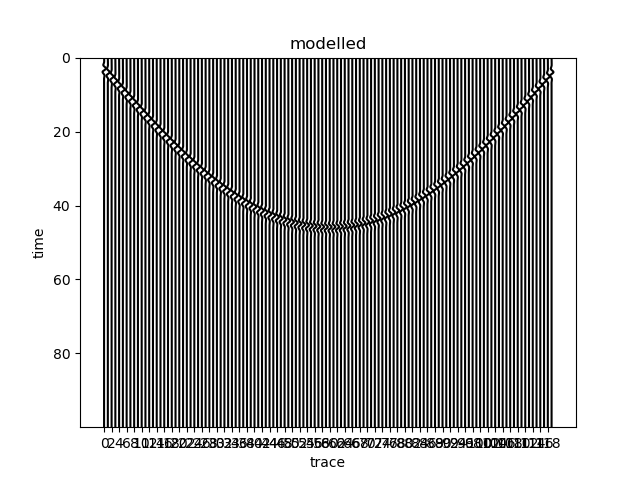

<IPython.core.display.Javascript object>


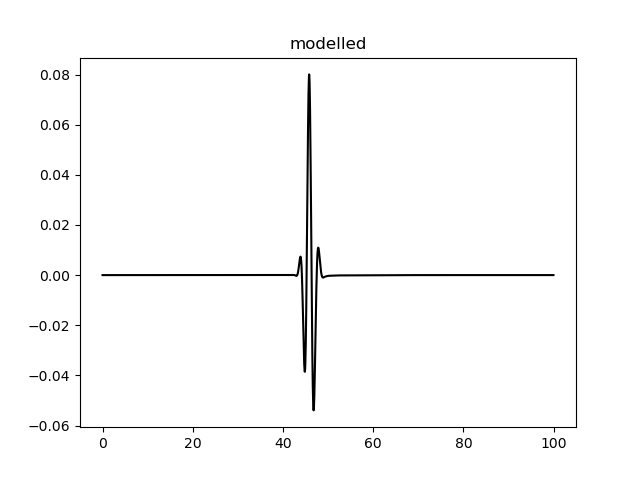

<AxesSubplot:title={'center':'modelled'}>

In [11]:
# Clear the previously compiled operator
pde.clear_operators()

# and run it forward
traces = await pde(shot.wavelets, vp, rho, alpha, problem=sub_problem, 
                   boundary_type="complex_frequency_shift_PML_2")

# Plot the resulting traces
_ = traces.plot()
traces.plot_one(60)

## Running on the GPU

The Devito operators that are generated by Stride can run both on the CPU and on the GPU. By default, operators will run on the CPU using thread-level parallelism with OpenMP.

To run the PDE on an available GPU, we can call the operator using an additional argument `pde(..., platform="nvidia-acc")`.

For more fine-grained control of the operator-generation behaviour at the Devito layer, the keyword arguments `devito_config` and `devito_args` are also available.  For example, using `pde(..., platform="nvidia-acc")` is equivalent to `pde(..., devito_config=dict(compiler="pgcc", language="openacc", platform="nvidiaX"))`.

## Other arguments

Our `IsoAcousticDevito` operator has a number of other arguments that will allow you to tailor the solver behaviour to your needs. 

For more information about these arguments, feel free to explore the documentation of this class:

In [12]:
print(IsoAcousticDevito.__doc__)


    This class represents the second-order isotropic acoustic wave equation,
    implemented using Devito.

    Parameters
    ----------
    name : str, optional
        Name of the PDE, defaults to an automatic name.
    grid : Grid, optional
        Existing grid, if not provided one will be created. Either a grid or
        space, time and slow_time need to be provided.
    space : Space, optional
    time : Time, optional
    slow_time : SlowTime, optional

    Notes
    -----

    For forward execution of the PDE, the following parameters can be used:

        wavelets : Traces
            Source wavelets.
        vp : ScalarField
            Compressional speed of sound fo the medium, in [m/s].
        rho : ScalarField, optional
            Density of the medium, defaults to homogeneous, in [kg/m^3].
        alpha : ScalarField, optional
            Attenuation coefficient of the medium, defaults to 0, in [Np/m].
        problem : Problem
            Sub-problem being solved b